Isha Singh

21070122059

NN CA2 Code

Develop an adaptive firewall system that uses the LMS (Least Mean Squares) algorithm to continuously update firewall rules based on incoming network traffic patterns.



---



env setup and libs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import time

extract dataset

In [ ]:
url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
df = pd.read_csv(url, header=None)

rename cols

In [ ]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
           "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
           "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
           "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
           "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
           "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
           "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
           "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df.columns = columns

encode lavels and categ. features

In [ ]:
label_encoder = LabelEncoder()
df['protocol_type'] = label_encoder.fit_transform(df['protocol_type'])
df['service'] = label_encoder.fit_transform(df['service'])
df['flag'] = label_encoder.fit_transform(df['flag'])
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)  # 0 = normal, 1 = attack

feature selection

In [ ]:
df.drop(['num_outbound_cmds', 'is_host_login'], axis=1, inplace=True)

test train split

In [ ]:
X = df.drop(['label'], axis=1)
y = df['label']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = y_train.reset_index(drop=True).to_numpy()
y_test = y_test.reset_index(drop=True).to_numpy()

lms algo

In [ ]:
class LMSFirewall:
    def __init__(self, learning_rate=0.0001):
        self.lr = learning_rate
        self.weights = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y, epochs=100):
        if self.weights is None:
            self.weights = np.random.randn(X.shape[1]) * 0.01
        errors = []
        for epoch in range(epochs):
            total_error = 0
            for i in range(X.shape[0]):
                xi = X[i]
                target = y[i]
                prediction = self.sigmoid(np.dot(xi, self.weights))
                error = target - prediction
                self.weights += self.lr * error * xi * prediction * (1 - prediction)
                total_error += error**2
            errors.append(total_error / X.shape[0])
        return errors

    def predict(self, X):
        return np.where(self.sigmoid(np.dot(X, self.weights)) >= 0.5, 1, 0)

    def update(self, x, y):
        prediction = self.sigmoid(np.dot(x, self.weights))
        error = y - prediction
        self.weights += self.lr * error * x * prediction * (1 - prediction)
        return error**2

simulated traditional firewall (doesnt use neural network)

In [ ]:
class TraditionalFirewall:
    def __init__(self, threshold_features):
        self.threshold_features = threshold_features

    def predict(self, X):
        predictions = []
        for sample in X:
            is_attack = False
            for feature, threshold in self.threshold_features.items():
                if feature == 1:  # protocol_type
                    if sample[feature] in threshold.values():
                        is_attack = True
                        break
                elif sample[feature] > threshold:
                    is_attack = True
                    break
            predictions.append(1 if is_attack else 0)
        return np.array(predictions)

to determine approx thresholds which we will use during test later

In [ ]:
def get_percentiles(df, columns, percentile=99):
    return {col: np.percentile(df[col], percentile) for col in columns}
numeric_columns = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count',
                   'dst_host_count', 'dst_host_srv_count']
thresholds = get_percentiles(df, numeric_columns)
thresholds['protocol_type'] = {'icmp': 1, 'tcp': 2, 'udp': 3}
traditional_firewall = TraditionalFirewall({
    0: thresholds['duration'],  # duration
    1: thresholds['protocol_type'],  # protocol_type
    4: thresholds['src_bytes'],  # src_bytes
    5: thresholds['dst_bytes'],  # dst_bytes
    22: thresholds['count'],  # count
    23: thresholds['srv_count'],  # srv_count
    31: thresholds['dst_host_count'],  # dst_host_count
    32: thresholds['dst_host_srv_count']  # dst_host_srv_count
})
print("Traditional Firewall Thresholds:")
for key, value in traditional_firewall.threshold_features.items():
    print(f"Feature {key}: {value}")

Traditional Firewall Thresholds:
Feature 0: 88.0
Feature 1: {'icmp': 1, 'tcp': 2, 'udp': 3}
Feature 4: 2394.7999999999884
Feature 5: 12260.0
Feature 22: 511.0
Feature 23: 511.0
Feature 31: 255.0
Feature 32: 255.0


function to simulate live traffic from dataset but random pkts in sets or sole

In [ ]:
def simulate_traffic(X, y, num_packets=1000):
    indices = np.random.choice(len(X), num_packets)
    return X[indices], y[indices]

evaluation and confusion matrix plot

In [ ]:
def evaluate_firewall(firewall, X, y, firewall_name):
    y_pred = firewall.predict(X)
    accuracy = np.mean(y_pred == y)
    print(f"{firewall_name} Accuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot()
    plt.title(f"{firewall_name} Confusion Matrix")
    plt.show()

    report = classification_report(y, y_pred, target_names=['Normal', 'Attack'])
    print(f"{firewall_name} Classification Report:\n", report)

comparison between firewalls

In [ ]:
def live_firewall_comparison(lms_firewall, traditional_firewall, X, y, num_packets=10000, update_interval=1000):
    X_stream, y_stream = simulate_traffic(X, y, num_packets)
    total_packets = 0
    lms_correct = 0
    traditional_correct = 0
    for i in range(num_packets):
        packet = X_stream[i].reshape(1, -1)
        true_label = y_stream.iloc[i]
        lms_prediction = lms_firewall.predict(packet)[0]
        lms_firewall.update(packet[0], true_label)
        traditional_prediction = traditional_firewall.predict(packet)[0]
        total_packets += 1
        if lms_prediction == true_label:
            lms_correct += 1
        if traditional_prediction == true_label:
            traditional_correct += 1
        if (i + 1) % update_interval == 0:
            lms_accuracy = lms_correct / total_packets
            traditional_accuracy = traditional_correct / total_packets
            print(f"Processed {total_packets} packets.")
            print(f"LMS Firewall accuracy: {lms_accuracy:.4f}")
            print(f"Traditional Firewall accuracy: {traditional_accuracy:.4f}")
            print("--------------------")
        time.sleep(0.01)
    final_lms_accuracy = lms_correct / total_packets
    final_traditional_accuracy = traditional_correct / total_packets
    print(f"Final LMS Firewall accuracy: {final_lms_accuracy:.4f}")
    print(f"Final Traditional Firewall accuracy: {final_traditional_accuracy:.4f}")

training

In [ ]:
lms_firewall = LMSFirewall(learning_rate=0.01)
training_errors = lms_firewall.fit(X_train, y_train, epochs=100)

mse curve

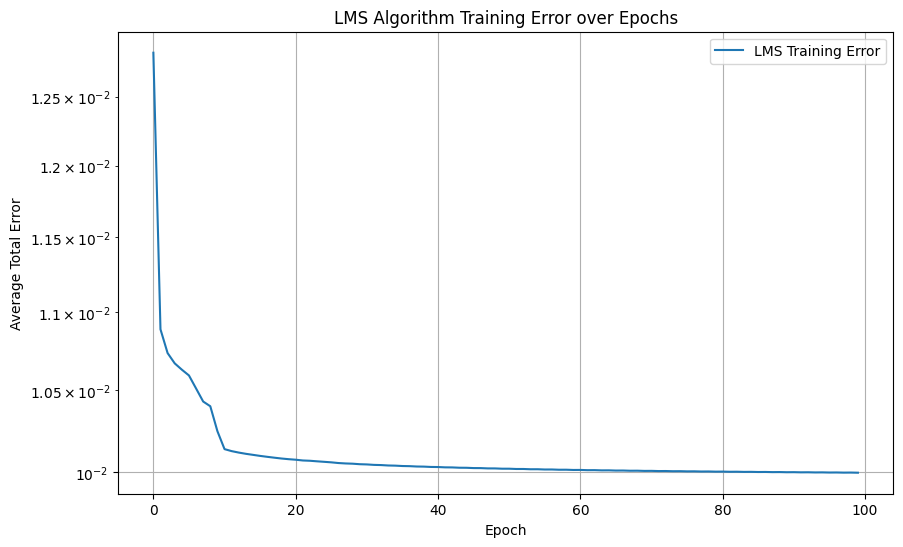

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(training_errors, label="LMS Training Error")
plt.title("LMS Algorithm Training Error over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Total Error")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

testing

In [ ]:
import matplotlib.pyplot as plt

def plot_firewall_comparison(graph_data):
    packets = [data['packets'] for data in graph_data]
    lms_accuracy = [data['lmsAccuracy'] for data in graph_data]
    traditional_accuracy = [data['traditionalAccuracy'] for data in graph_data]

    plt.figure(figsize=(12, 6))
    plt.plot(packets, lms_accuracy, label='LMS Firewall', marker='o')
    plt.plot(packets, traditional_accuracy, label='Traditional Firewall', marker='s')
    plt.title('Firewall Accuracy Comparison')
    plt.xlabel('Packets Processed')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

Evaluating firewalls on test set:
LMS Firewall Accuracy: 98.99%


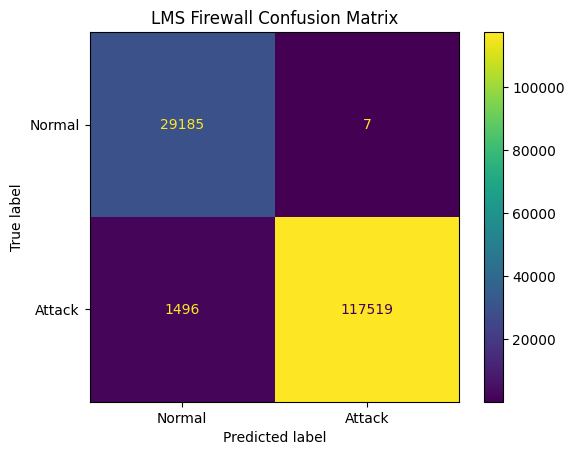

LMS Firewall Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      1.00      0.97     29192
      Attack       1.00      0.99      0.99    119015

    accuracy                           0.99    148207
   macro avg       0.98      0.99      0.98    148207
weighted avg       0.99      0.99      0.99    148207

Traditional Firewall Accuracy: 19.70%


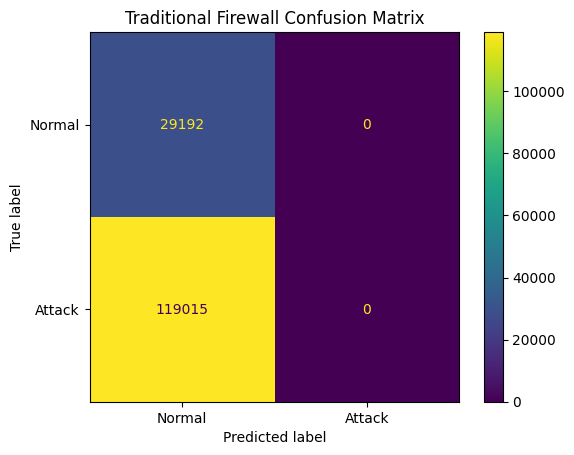

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Traditional Firewall Classification Report:
               precision    recall  f1-score   support

      Normal       0.20      1.00      0.33     29192
      Attack       0.00      0.00      0.00    119015

    accuracy                           0.20    148207
   macro avg       0.10      0.50      0.16    148207
weighted avg       0.04      0.20      0.06    148207


Starting live firewall comparison...
Processed 1000 packets.
LMS Firewall accuracy: 0.9920
Traditional Firewall accuracy: 0.1910
--------------------
Processed 2000 packets.
LMS Firewall accuracy: 0.9930
Traditional Firewall accuracy: 0.1920
--------------------
Processed 3000 packets.
LMS Firewall accuracy: 0.9937
Traditional Firewall accuracy: 0.1937
--------------------
Processed 4000 packets.
LMS Firewall accuracy: 0.9928
Traditional Firewall accuracy: 0.1953
--------------------
Processed 5000 packets.
LMS Firewall accuracy: 0.9912
Traditional Firewall accuracy: 0.1972
--------------------
Processed 6000 packets.
L

In [ ]:
print("Evaluating firewalls on test set:")
evaluate_firewall(lms_firewall, X_test, y_test, "LMS Firewall")
evaluate_firewall(traditional_firewall, X_test, y_test, "Traditional Firewall")
print("\nStarting live firewall comparison...")
live_firewall_comparison(lms_firewall, traditional_firewall, X, y, num_packets=10000, update_interval=1000)

final results


Final evaluation on test set:
LMS Firewall (After live traffic) Accuracy: 98.99%


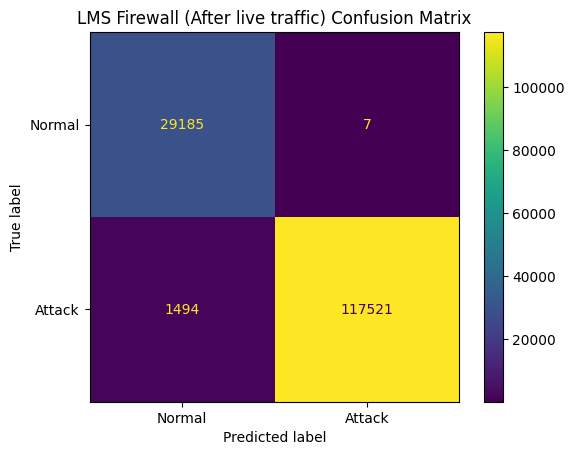

LMS Firewall (After live traffic) Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      1.00      0.97     29192
      Attack       1.00      0.99      0.99    119015

    accuracy                           0.99    148207
   macro avg       0.98      0.99      0.98    148207
weighted avg       0.99      0.99      0.99    148207

Traditional Firewall Accuracy: 19.70%


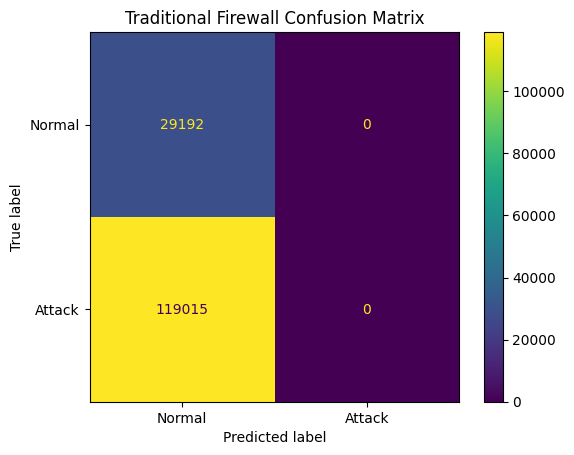

Traditional Firewall Classification Report:
               precision    recall  f1-score   support

      Normal       0.20      1.00      0.33     29192
      Attack       0.00      0.00      0.00    119015

    accuracy                           0.20    148207
   macro avg       0.10      0.50      0.16    148207
weighted avg       0.04      0.20      0.06    148207



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("\nFinal evaluation on test set:")
evaluate_firewall(lms_firewall, X_test, y_test, "LMS Firewall (After live traffic)")
evaluate_firewall(traditional_firewall, X_test, y_test, "Traditional Firewall")

In [ ]:
y_pred = lms_firewall.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.99%
